In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math


최종시간 = 17.050 s
미사일 최종위치 = (4994.02, 3.79)
미사일 최종 진행각(deg) = -31.43
표적과 거리 = 7.08 m


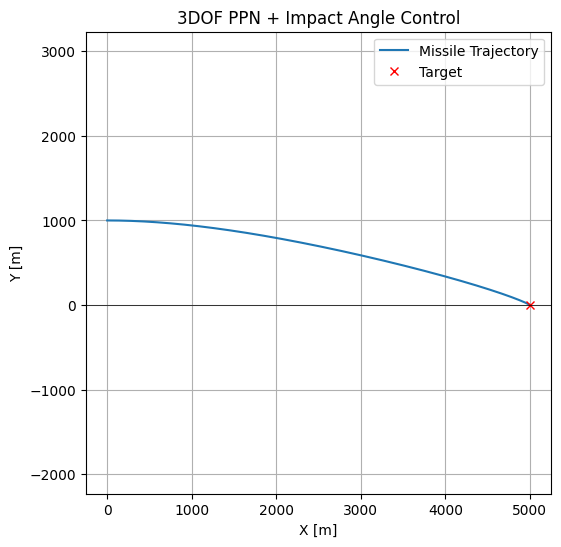

In [18]:
def simulate_impact_angle_control(
    x0=0.0, y0=0.0, psi0=np.deg2rad(30.0), # 초기 위치, 초기 진행각(30도)
    V=300.0,                               # 미사일 속력 (m/s 가정)
    target_x=5000.0, target_y=0.0,      # 표적 위치
    psi_final_deg=-90.0,                   # 원하는 종말 충돌각 (deg) 예: -90도(수직 낙하)
    N=5.0,                                 # PN의 Navigation constant
    dt=0.01,                               # 시뮬레이션 시간 간격
    t_max=120.0                             # 최대 시뮬레이션 시간
):
    """
    3자유도( x, y, psi ) 미사일 모델로 Proportional Navigation + Impact Angle 보정 항을
    사용하여 표적을 추적하는 시뮬레이션.
    """
    # 최종 충돌각(라디안)
    psi_f = np.deg2rad(psi_final_deg)
    
    # 저장용 리스트
    time_log = []
    x_log = []
    y_log = []
    psi_log = []
    
    # 초기 상태
    t = 0.0
    x = x0
    y = y0
    psi = psi0
    
    # 반복 시뮬레이션
    while t < t_max:
        # 현재 표적과의 거리
        dx = target_x - x
        dy = target_y - y
        r  = np.hypot(dx, dy)  # 거리 sqrt(dx^2 + dy^2)

        # 만약 표적 근처에 왔다면 종료
        if r < 5.0:  # 5미터 이내 접근 시 '명중'으로 간주
            break
        
        # LOS 각도 lambda
        lam = np.arctan2(dy, dx)
        
        # 상대속도(Closing velocity) 계산
        # 여기선 표적이 정지해 있다고 가정
        # 미사일의 속도벡터는 (V cos psi, V sin psi)
        # 표적->미사일 방향단위벡터는 (-dx/r, -dy/r)이므로
        #  V_closing = (missile_velocity) dot (target->missile_unit)
        #            = - (V cos psi * dx + V sin psi * dy) / r
        # (음수값이지만, PN 법칙은 절댓값 혹은 부호처리를 적절히 함)
        closing_vel = - (V * np.cos(psi)*dx + V * np.sin(psi)*dy) / r
        
        # LOS 각도 변화율 lam_dot 근사
        # lam_dot = -1/r * (상대속도_x * sin(lam) - 상대속도_y * cos(lam)) ...
        # 하지만 간단히 "lam_dot ≈ (d lam / dt)"를 수치적으로 구해도 됨.
        # 여기서는 한 스텝 전의 lam과 비교로 근사하거나, PN 공식 등을 직접 사용.
        # 간단화 위해 lam_dot = (closing_vel / r) * sin(heading_error) 라고도 씀.
        # 여기서는 heading_error = lam - psi
        heading_error = lam - psi
        lam_dot = (closing_vel / r) * np.sin(heading_error)
        
        # 남은 비행시간 t_go 근사
        # 보통 t_go = r / closing_vel (절댓값)
        # closing_vel이 음수일 수 있으므로, 절댓값 처리
        t_go = r / max(abs(closing_vel), 1e-6)
        
        # ------ Impact Angle 보정 항 ------
        # 종말 각도(psi_f)와 현재 psi가 t_go 후에 맞아떨어지도록 하는 간단한 비례제어
        # 예: a_ic = k * ( (psi - psi_f) / t_go )
        # 여기서 k는 튜닝 파라미터(아래서는 임의 2*N 등)
        # 실제론 논문/교재별로 다양한 설계식이 존재
        k_ic = 10.0 * N  # 임의 설정
        angle_err = (psi - psi_f)
        a_ic = k_ic * angle_err / max(t_go, 0.1)
        
        # ------ PN 가속도 항 ------
        # a_pn = N * closing_vel * lam_dot
        a_pn = N * closing_vel * lam_dot
        
        # 최종적으로 수직가속도 합
        a_normal = a_pn + a_ic
        
        # 방위각 변화율 dpsi/dt = a_normal / V
        dpsi_dt = a_normal / V
        
        # 오일러 적분 (단순 전진오일러)
        psi_new = psi + dpsi_dt * dt
        x_new   = x   + V * np.cos(psi) * dt
        y_new   = y   + V * np.sin(psi) * dt
        
        # 로그 저장
        time_log.append(t)
        x_log.append(x)
        y_log.append(y)
        psi_log.append(psi)
        
        # 상태 업데이트
        t += dt
        x = x_new
        y = y_new
        psi = psi_new

    return np.array(time_log), np.array(x_log), np.array(y_log), np.array(psi_log)

# ------------------------- 시뮬레이션 실행 예시 -------------------------
if __name__ == "__main__":
    # 초기 조건
    x0 = 0.0
    y0 = 1000.0          # 미사일 초기 고도
    psi0_deg = 0.0       # 초기 진행각(수평방향)
    psi0 = np.deg2rad(psi0_deg)
    V = 300.0            # 미사일 속력 (m/s)
    
    # 표적
    tx, ty = (5000.0,0.0)   # 표적은 (5000, 0)에 정지해 있다고 가정
    
    # 원하는 종말 각도: 예) -90도(수직 하향 타격)
    psi_final_deg = -90.0
    
    # PN Gain
    N = 5.0
    
    # 시뮬레이션
    t_log, x_log, y_log, psi_log = simulate_impact_angle_control(
        x0=x0, y0=y0, psi0=psi0,
        V=V,
        target_x=tx, target_y=ty,
        psi_final_deg=psi_final_deg,
        N=N,
        dt=0.01,
        t_max=120.0
    )
    
    # 최종 상태 확인
    print(f"최종시간 = {t_log[-1]:.3f} s")
    print(f"미사일 최종위치 = ({x_log[-1]:.2f}, {y_log[-1]:.2f})")
    print(f"미사일 최종 진행각(deg) = {np.rad2deg(psi_log[-1]):.2f}")
    dist_to_target = np.hypot(tx - x_log[-1], ty - y_log[-1])
    print(f"표적과 거리 = {dist_to_target:.2f} m")
    
    # 궤적 시각화
    plt.figure(figsize=(6,6))
    plt.plot(x_log, y_log, label='Missile Trajectory')
    plt.plot(tx, ty, 'rx', label='Target')
    plt.axhline(0, color='k', linewidth=0.5)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('3DOF PPN + Impact Angle Control')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()



최종시간 = 17.050 s
미사일 최종위치 = (4993.65, 2.51)
미사일 최종 진행각(deg) = -21.21
표적과 거리 = 6.83 m


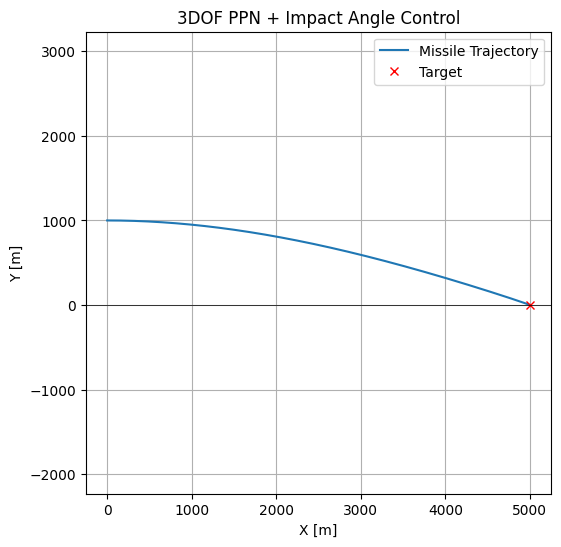